In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from dataclasses import asdict

import math
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from minitorch.module import Network, Linear
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid

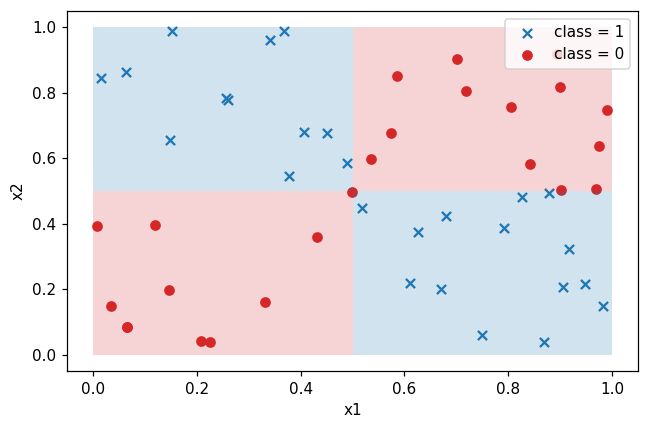

In [3]:
# Create a dataset
dataset_type = DatasetTypes.xor

datasets = Datasets.generate_datasets(n_samples=50)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue", label="class = 1")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red", label="class = 0")
ax.legend(loc=1)

bottom_left = Rectangle((0, 0), 0.5, 0.5, color="tab:red", alpha=0.2, lw=0.0)
top_right = Rectangle((0.5, 0.5), 0.5, 0.5, color="tab:red", alpha=0.2, lw=0.0)
top_left = Rectangle((0.0, 0.5), 0.5, 0.5, color="tab:blue", alpha=0.2, lw=0.0)
bottom_right = Rectangle((0.5, 0.0), 0.5, 0.5, color="tab:blue", alpha=0.2, lw=0.0)
ax.add_patch(bottom_left)
ax.add_patch(bottom_right)
ax.add_patch(top_left)
ax.add_patch(top_right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

In [4]:
# Create a network
network = Network(input_dim=2, hidden_dim=10, output_dim=1)

In [5]:
# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.3)

In [6]:
# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [ ]:
# Training loop
n_epochs = 150
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]

    # Compute a loss
    loss_per_epoch = 0
    for i in range(len(y_true)):
        loss_per_epoch += (y_hat[i][0].log() if y_true[i] == 1.0 else (- y_hat[i][0] + 1).log())
    loss_per_epoch = (- loss_per_epoch / len(y_true))
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

In [8]:
y_hat = network.forward(X)
y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
y_hat_classes = [[1 if proba.data >= 0.5 else 0 for proba in row] for row in y_hat]
y_hat_classes = list(itertools.chain.from_iterable(y_hat_classes))

In [9]:
# Accuraccy
sum(
    [
        1 if y_hat_c == y_true_c 
        else 0 for (y_hat_c, y_true_c) in zip(y_hat_classes, y_true)
    ]
) / len(y_true)

0.8

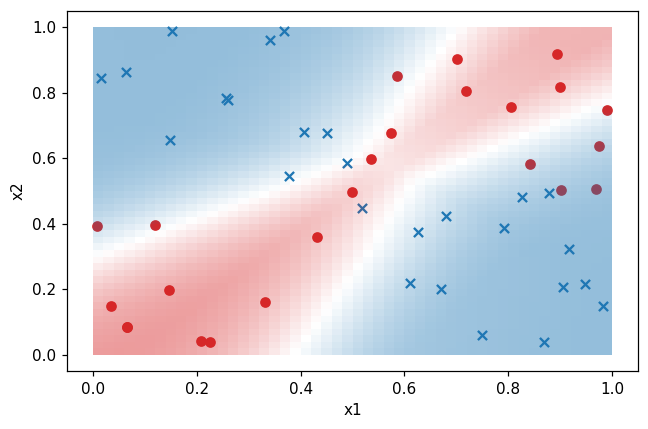

In [11]:
# Visualising predictions

# Plot original data
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Generate mesh for predictions
n_steps = 51
x1_positions = list(np.linspace(0, 1.0, n_steps))
x2_positions = list(np.linspace(0, 1.0, n_steps))

# Generate predictions for each point on mesh
y_hat = np.zeros(shape=(n_steps, n_steps))
for i, x1 in enumerate(x1_positions):
    X = [[x1, x2] for x2 in x2_positions]
    y_hat_ = network.forward(X)
    y_hat_ = [[s.sigmoid().data for s in sample] for sample in y_hat_]
    y_hat[:, i] = np.array(y_hat_).flatten()


# Plot predictions as rectangles
for i, (x1_lower, x1_upper) in enumerate(zip(x1_positions, x1_positions[1:])):
    for j, (x2_lower, x2_upper) in enumerate(zip(x2_positions, x2_positions[1:])):
        rect = Rectangle(
            (x1_lower, x2_lower), 
            (x1_upper - x1_lower),
            (x2_upper - x2_lower), 
            color="tab:blue" if y_hat[i, j] >= 0.5 else "tab:red",
            alpha=(y_hat[i, j] - 0.5) if y_hat[i, j] >= 0.5 else (0.5 - y_hat[i, j]),
            lw=0.0
        )
        ax.add_patch(rect)

        
ax.set_xlabel("x1")
ax.set_ylabel("x2")
fig.tight_layout();